In [2]:
%matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

import measurement
import echo
import distance
import image

Using matplotlib backend: MacOSX


In [2]:
# choose dataset
fname = 'datasets/set_fs_32000_1.mat'
dataset = sio.loadmat(fname)

In [9]:
fs = float(dataset['fs'])
M = int(dataset['M'])
N = int(dataset['N'])
h = float(dataset['h'])
l = float(dataset['l'])
w = float(dataset['w'])
r = dataset['receivers']
s = dataset['sources']
data = dataset['data'].T
c = float(dataset['c'])

maxsize = np.sqrt(w**2+l**2+h**2) #m
max_delay = maxsize / float(c) 
maxlength = int(2 * max_delay * fs)
room = np.array([[ [0,0], [0,l], [w,l], [w,0]]])
measurements  = [measurement.MeasurementData(data=np.hstack(source_data).T, 
                                 receivers=r, 
                                 sources=s[i], 
                                 room_dimensions=(w,l,h), 
                                 c=c, 
                                 fs=fs) 
                 for i,source_data in enumerate(data)]

In [10]:
echo_data = [echo.EchoData(m.find_echoes(crop=maxlength, interpolate=10)) for m in measurements]

In [11]:
D = measurement.squared_distance_matrix(r, augmented=True)
N = 8
S, E = zip(*[e.find_labels(D,threshold=0.005, parallel=True, verbose=True) for e in echo_data[:N]])
E = [e for e in E if len(e) > 0]
S = np.vstack(S)

Finding echo_set candidates per measurement ...
prefilter threshold: 0.005
Ci: 61
prefilter threshold: 0.01
Ci: 133
prefilter threshold: 0.02
Number of unique sets of 6 echo_sets: 0
Finding echo_set candidates per measurement ...
prefilter threshold: 0.005
Ci: 33
Number of unique sets of 6 echo_sets: 2
Finding echo_set candidates per measurement ...
prefilter threshold: 0.005
Ci: 49
prefilter threshold: 0.01
Ci: 90
prefilter threshold: 0.02
Ci: 189
prefilter threshold: 0.04
Number of unique sets of 6 echo_sets: 0
Finding echo_set candidates per measurement ...
prefilter threshold: 0.005
Ci: 48
Number of unique sets of 6 echo_sets: 12
Finding echo_set candidates per measurement ...
prefilter threshold: 0.005
Ci: 40
Number of unique sets of 6 echo_sets: 2
Finding echo_set candidates per measurement ...
prefilter threshold: 0.005
Ci: 44
prefilter threshold: 0.01
Ci: 94
prefilter threshold: 0.02
Ci: 169
prefilter threshold: 0.04
Number of unique sets of 6 echo_sets: 0
Finding echo_set cand

In [16]:
distancedata = distance.DistanceData(S,E)
results = distancedata.find_images(r)
print(sorted(results.keys())[0:10])

[0.053463855177171234, 0.061766397307052225, 0.076615913700704308, 0.085669533446870977, 0.10149450881011561, 0.10941304712214361, 0.11033210020027578, 0.12364100395173785, 0.13741942095240697, 0.14866385570144316]


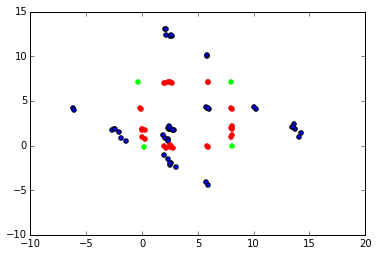

In [17]:
if len(results) > 0:
    imagedata = image.ImageSourceData(results, N, r, (w,l,h))
    wall_points,vertices = imagedata.find_walls(threshold=0.1, bestN=10)
    if len(vertices) == 4:
        im = np.vstack(imagedata.images)
        plt.scatter(im[:,0], im[:,1])
        wp = np.vstack(wall_points)
        plt.scatter(wp[:,0], wp[:,1], color=(1,0,0,1))
        plt.scatter(vertices[:,0], vertices[:,1], color=(0,1,0,1))

# Room size experiment

In [41]:
results = np.load('results_dictionary.npy')

In [42]:
results

array(defaultdict(<class 'list'>, {96000.0: [0.16480485099318642, 0.009548104984421794, 0.097985934634942873, 0.05294248232883858]}), dtype=object)

In [43]:
type(results)

numpy.ndarray

In [44]:
len(results)

TypeError: len() of unsized object

In [36]:
collections.defaultdict(results)

TypeError: first argument must be callable

In [3]:
import collections

In [4]:
import pickle

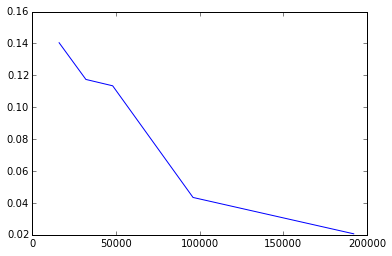

In [88]:
y = []
x = []
with open('fs_1x_results', 'rb') as f:
    results = pickle.load(f)
for k in sorted(results.keys()):
    if k < 40000:
        x.append(k)
        y.append(np.mean(results[k]))


with open('fs_mc_1x_results', 'rb') as f:
    results = pickle.load(f)
for k in sorted(results.keys()):
    if k > 40000:
        x.append(k)
        y.append(np.mean(results[k]))

plt.plot(x, y)

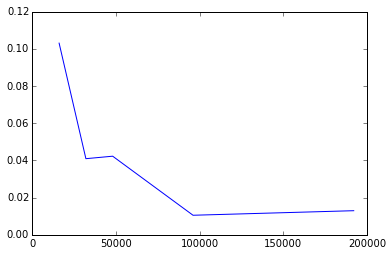

In [87]:
y = []
x = []
with open('fs_10x_results', 'rb') as f:
    results = pickle.load(f)
for k in sorted(results.keys()):
    if k < 40000:
        x.append(k)
        y.append(np.mean(results[k]))


with open('fs_mc_10x_results', 'rb') as f:
    results = pickle.load(f)
for k in sorted(results.keys()):
    if k > 40000:
        x.append(k)
        y.append(np.mean(results[k]))

plt.plot(x, y)

In [113]:
def plot_fs(ax, d1, d2, label=None, color=None):
    y = []
    x = []
    with open(d1, 'rb') as f:
        results = pickle.load(f)
    for k in sorted(results.keys()):
        if k < 40000:
            x.append(k)
            y.append(np.mean(results[k]))


    with open(d2, 'rb') as f:
        results = pickle.load(f)
    for k in sorted(results.keys()):
        if k > 40000:
            x.append(k)
            y.append(np.mean(results[k]))

    ax.plot(x, y, 'o-', linewidth=2, label=label, color=color)
    plt.legend(loc='best')

In [130]:
fig = plt.figure()
ax = fig.gca()
plot_fs(ax, 'fs_1x_results', 'fs_mc_1x_results', color=tudelft_cyan, label="No upsampling")
plot_fs(ax, 'fs_10x_results', 'fs_mc_10x_results', color=tudelft_orange, label="10x upsampling")
plot_fs(ax, 'fs_100x_results', 'fs_mc_100x_results', color=tudelft_purple, label="100x upsampling")
plt.xlabel('Sample Frequency [Hz]')
plt.ylabel('Room estimation error [m]')
plt.grid('on')
plt.xticks((16000, 32000, 48000, 96000, 2*96000), ('16k', '32k', '48k', '96k', '192k'), color=tudelft_black)
plt.show()

In [126]:
help(plt.xticks)

Help on function xticks in module matplotlib.pyplot:

xticks(*args, **kwargs)
    Get or set the *x*-limits of the current tick locations and labels.
    
    ::
    
      # return locs, labels where locs is an array of tick locations and
      # labels is an array of tick labels.
      locs, labels = xticks()
    
      # set the locations of the xticks
      xticks( arange(6) )
    
      # set the locations and labels of the xticks
      xticks( arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue') )
    
    The keyword args, if any, are :class:`~matplotlib.text.Text`
    properties. For example, to rotate long labels::
    
      xticks( arange(12), calendar.month_name[1:13], rotation=17 )



In [28]:
from matplotlib.colors import ColorConverter

cc = ColorConverter()

# colors
tudelft_cyan = cc.to_rgba("#00ADEF")
tudelft_black = cc.to_rgba("#231F20")
tudelft_white = cc.to_rgba("#FFFFFF")
tudelft_sea_green = cc.to_rgba("#70C8BB")
tudelft_green = cc.to_rgba("#0097A1")
tudelft_dark_blue = cc.to_rgba("#1B1464")
tudelft_purple = cc.to_rgba("#211869")
tudelft_turquoise = cc.to_rgba("#00A9BD")
tudelft_sky_blue = cc.to_rgba("#7AC6DC")
tudelft_lavender = cc.to_rgba("#7FA7D0")
tudelft_orange = cc.to_rgba("#F0883F"   )
tudelft_warm_purple = cc.to_rgba("#80268C")
tudelft_fuchsia = cc.to_rgba("#A70576")
tudelft_bright_green = cc.to_rgba("#AFD135")
tudelft_yellow = cc.to_rgba("#FDF391")

In [309]:
#'N5_w5l7h3.5', 'N5_w8l7h3.5', 
#          'N5_w9l10h5', 'N5_w11l13h5', 'N5_w9l8h5', 'N5_w19l18h9', 
#         'N5_w15l15h6_', 

files = ['N5_w5l7h3.5', 'N5_w8l7h3.5', 'N5_w5l5h5', 'N5_w6l5h5', 'N5_w6l6h5', 'N5_w7l6h5', 'N5_w7l7h5', 
         'N5_w8l7h5', 'N5_w8l8h5', 'N5_w9l9h5', 'N5_w10l10h5', 'N5_w8l10h5'] #, 'N5_w8l7h5', 'N5_w9l8h5', 'N5_w9l10h5', 'N5_w11l13h5']

x = []
y = []
z = []
for file in files:
    with open(file, 'rb') as f:
        results = pickle.load(f)
    volume = sorted(results.keys())[0]
    results = results[volume]
    errors, times = zip(*results)
    print(volume,len(errors), len(errors)/50)
    y.append(np.array(errors))
    x.append(volume)
    z.append(np.array(times))
    
#i = np.argsort(x)
#x = np.array(x)[i]
#y = np.array(y)[i]
#z = np.array(z)[i]
x = np.array(x)
y = np.hstack(y)
z = np.hstack(z)



122.5 23 0.46
196.0 26 0.52
125.0 36 0.72
150.0 41 0.82
180.0 42 0.84
210.0 42 0.84
245.0 41 0.82
280.0 25 0.5
320.0 43 0.86
405.0 42 0.84
500.0 44 0.88
400.0 44 0.88


In [312]:
(len(y)-23-25)/500

0.802

In [292]:
np.mean(y)

0.023588281197365963

In [302]:
np.sqrt(np.var(y))

0.047074419706524331

In [295]:
np.min(y)

0.0010762506008891309

In [299]:
np.mean(z)

2.4253816737364025

In [300]:
np.var(z)

0.5143139991546718

In [301]:
np.min(z)

1.3486261367797852

In [53]:
with open('N_2-16', 'rb') as f:
    results = pickle.load(f)
NN = sorted(results.keys())
mean_err = []
mean_time = []
for N in NN:
    res = results[N]  
    errors, times = zip(*res)
    mean_err.append(np.mean(errors))
    mean_time.append(np.mean(times))

In [54]:
plt.figure(1)
plt.plot(NN, mean_err/mean_err[0], 'o-', linewidth=2, color=tudelft_cyan)
plt.grid('on')

In [55]:
plt.figure(2)
plt.plot(NN, mean_time, 'o-', linewidth=2, color=tudelft_orange)
plt.grid('on')

In [48]:
with open('N_2-16-1', 'rb') as f:
    results = pickle.load(f)
NN = sorted(results.keys())
mean_err = []
mean_time = []
for N in NN:
    res = results[N]  
    errors, times = zip(*res)
    mean_err.append(np.mean(errors))
    mean_time.append(np.mean(times))